<a href="https://colab.research.google.com/github/DongUk-Park/RnD/blob/main/POI/NAIS/DataPreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import csv
import os
import pandas as pd
import numpy as np
import random

#Data Untils

## RAW Data 생성

### Check_in Data 생성
리뷰 데이터로 체크인 데이터(user,business_id)를 만든다 <br>
원하는 데이터 정보 추가,삭제 : 13, 21 수정

In [ ]:
# JSON 파일 경로
json_file_path = '/content/drive/MyDrive/dataset/yelp_dataset/review.json'

# CSV 파일 경로
csv_file_path = '/content/checkin.csv'

# CSV 파일을 쓰기 모드로 열기
with open(csv_file_path, 'w', newline='') as csv_file:
    # CSV 라이터 생성
    csv_writer = csv.writer(csv_file)

    # CSV 파일 헤더 작성
    csv_writer.writerow(['user_id', 'business_id'])

    # JSON 파일을 한 줄씩 읽어서 처리
    with open(json_file_path, 'r', encoding='utf-8') as json_file:
        for line in json_file:
            data = json.loads(line)  # JSON 데이터 파싱

            # user_id와 business_id 추출
            user_id = data['user_id']
            business_id = data['business_id']

            # CSV 파일에 데이터 작성
            csv_writer.writerow([user_id, business_id])

print("checkin_data 생성 완료.")


checkin_data 생성 완료.


In [ ]:
"""
데이터 개수(row 수) 확인
"""

# CSV 파일 경로
csv_file_path = '/content/checkin.csv'

row_count = 0

# CSV 파일을 읽기 모드로 열고 행 수를 센다
with open(csv_file_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # 헤더 행을 건너뜁니다.
    for row in csv_reader:
        row_count += 1

print(f"CSV 파일의 행 수: {row_count}")

CSV 파일의 행 수: 6990280


### Business_info Data 생성
Business 데이터로 가게의 위치를 담은 데이터(business_id,location, city)를 만든다 <br>
원하는 데이터 정보 추가,삭제 : 13, 21 수정

In [ ]:
# JSON 파일 경로
json_file_path = '/content/drive/MyDrive/dataset/yelp_dataset/business.json'

# CSV 파일 경로
csv_file_path = '/content/business_info.csv'

# CSV 파일을 쓰기 모드로 열기
with open(csv_file_path, 'w', newline='') as csv_file:
    # CSV 라이터 생성
    csv_writer = csv.writer(csv_file)

    # CSV 파일 헤더 작성
    csv_writer.writerow(['business_id_num','business_id','latitude ','longitute', 'city'])

    # business_id 를 int형으로 변환
    idx = 0

    # JSON 파일을 한 줄씩 읽어서 처리
    with open(json_file_path, 'r', encoding='utf-8') as json_file:
        for line in json_file:
            data = json.loads(line)  # JSON 데이터 파싱

            # user_id와 business_id 추출
            business_id_num = idx
            business_id = data['business_id']
            latitude = data['latitude']
            longitude = data['longitude']
            city = data['city']

            # CSV 파일에 데이터 작성
            csv_writer.writerow([business_id_num, business_id, latitude, longitude, city])
            idx += 1

print("CSV 파일 생성 완료.")


CSV 파일 생성 완료.


In [ ]:
"""
데이터 개수(row 수) 확인
"""
# CSV 파일 경로
csv_file_path = '/content/business_info.csv'

row_count = 0

# CSV 파일을 읽기 모드로 열고 행 수를 센다
with open(csv_file_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # 헤더 행을 건너뜁니다.
    for row in csv_reader:
        row_count += 1

print(f"CSV 파일의 행 수: {row_count}")

CSV 파일의 행 수: 150346


In [ ]:
"""
business_info에서 philadelphia에 속한 가게만 남김
"""

df = pd.read_csv('/content/business_info.csv')

# city 칼럼에서 "philadelphia"인 행만 선택
filtered_df = df[df['city'].str.contains("phila", case=False, na=False)]

# 필터링된 데이터를 CSV 파일로 저장
filtered_df.to_csv('/content/business_info_in_philadelphia.csv', index=False)

print("CSV 파일 필터링 및 저장 완료.")
filtered_df.shape

business_id_list = filtered_df['business_id_num'].tolist()
print(business_id_list[:5])

CSV 파일 필터링 및 저장 완료.
[3, 15, 19, 28, 31]


## 사용자 방문데이터(위치포함) 생성
위에서 생성한 데이터 두개를 합친 방문데이터 생성 <br>
checkin + business_info => location과 city 확인<br>
Philadelphia 도시에 대한 데이터만 남김

In [ ]:
# business_info.csv 파일 경로
business_info_file = '/content/business_info.csv'

# checkin_data.csv 파일 경로
checkin_data_file = '/content/checkin.csv'

# 새로운 CSV 파일 경로 (결과 저장용)
output_file = '/content/checkin_data_in_philadelphia.csv'

# business_id를 키로 한 dictionary 생성
business_location = {}
with open(business_info_file, 'r', newline='') as business_file:
    csv_reader = csv.reader(business_file)
    next(csv_reader)  # 헤더 행 건너뛰기
    for row in csv_reader:
        business_id_num, business_id, latitude, longitude, city = row[0], row[1], row[2], row[3], row[4].lower() #city : 소문자로 받음
        business_location[business_id] = (business_id_num, latitude, longitude, city)

count = 0 # 잘 다 들어갔는지 체크
mcount = 0 # 잘 안들어간거 있는지 체크
not_phila = 0

# 새로운 CSV 파일(output_file : checkin_data_in_philadelphia)을 작성하여 business_id, latitude, longitude를 추가
with open(checkin_data_file, 'r', newline='') as checkin_file, open(output_file, 'w', newline='') as output_csv:
    csv_reader = csv.reader(checkin_file)
    csv_writer = csv.writer(output_csv)

    # 헤더 행 작성
    header = next(csv_reader)
    header.extend(['business_id', 'latitude', 'longitude', 'city'])
    csv_writer.writerow(header)

    for row in csv_reader:
        business_id = row[1]
        if business_id in business_location:
            business_id_num, latitude, longitude, city = business_location[business_id]

            # city가 "philadelphia"인 경우에만 데이터를 CSV 파일에 작성
            if "philadelphia" in city: #philadelphia 에서 오타가 존재할 수 있기 때문에 "phila"만 검사
              row.extend([business_id_num, latitude, longitude, city])
              # business_id 열을 제외한 열만 저장
              csv_writer.writerow(row[0:1] + row[2:])
              count += 1
            else:
              not_phila += 1
        else:
            # 해당 business_id가 business_info.csv에 없을 경우, 스킵
            mcount += 1
            continue

print("CSV 파일에 위치 정보가 추가되었습니다.")
print(count, mcount, not_phila) #philadelphia, 에러, 다른도시


CSV 파일에 위치 정보가 추가되었습니다.
968050 0 6022230


user_id 순으로 정렬

In [ ]:
# CSV 파일 경로
input_file = '/content/checkin_data_in_philadelphia.csv'
output_file = '/content/checkin_data_final.csv'

# CSV 파일을 읽고 데이터를 리스트로 저장
data = []
with open(input_file, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)  # 헤더 행
    data.append(header)
    for row in csv_reader:
        data.append(row)

# user_id를 기준으로 데이터를 정렬

print(data[:3])

data = data[1:] # header행 삭제
data.sort(key=lambda x: x[0])  # 여기서 0은 user_id 열을 가리킵니다. 0부터 시작하면 첫 번째 열입니다.

# user_id를 정수형으로 변환
idx = 0
before_user_id = data[0][0]
for i in data:
  if i[0] == before_user_id:
    i[0] = idx
  else:
    idx += 1
    before_user_id = i[0]
    i[0] = idx


# 정렬된 데이터를 새로운 파일에 저장
with open(output_file, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(data)

print("CSV 파일이 user_id를 기준으로 정렬되었고, 새로운 파일에 저장되었습니다.")

[['user_id', 'business_id', 'business_id', 'latitude', 'longitude', 'city'], ['OyoGAe7OKpv6SyGZT5g77Q', '12886', '39.9521029', '-75.1727526', 'philadelphia'], ['_7bHUi9Uuf5__HHc_Q8guQ', '6316', '40.0798480557', '-75.025079772', 'philadelphia']]
CSV 파일이 user_id를 기준으로 정렬되었고, 새로운 파일에 저장되었습니다.


In [ ]:
"""
train에 사용될 history 데이터 (2차원 리스트)
인덱스 번호 : user_Id
인덱스 value(list형식) : 해당 uesr가 방문한 business_id 리스트
"""

history_list = []
tmp = []
before_user_id = 0
for idx, i in enumerate(data):
  if i[0] == before_user_id:
    tmp.append(i[1])
  else:
    if len(tmp) >= 10: # 방문 횟수가 10회가 넘는 유저만 append
      history_list.append(tmp)

    tmp = []
    tmp.append(i[1])
    before_user_id += 1

  if idx == len(data) - 1:
    history_list.append(tmp)

output_file = '/content/history_list.csv'
with open(output_file, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(history_list)

In [ ]:
print(len(history_list))

sum = 0
for i in history_list:
  sum += len(i)
print(sum)

15919
465587


## Test,Validation,Train Data 생성

In [ ]:
"""
위 history_list를 train, validation, test 데이터셋으로 분리시킴
"""

train_ratio = 0.6
test_ratio = 0.2
validation_ratio = 0.2

train_dataset = []
test_dataset = []
validation_dataset = []

train_negative_dataset = [] # business_id 개수 : 150346개
validation_negative_dataset = []
test_negative_dataset = []


#아래의 결과를 csv 파일로 저장할 경로, 총 6개의 파일 생성
output_train = '/content/history_train.csv'
output_validation = '/content/history_validation.csv'
output_test = '/content/history_test.csv'


for user, history in enumerate(history_list):
  ### 한 유저에 대해 train,validation,test dataset 생성
  total_samples = len(history) # 방문 횟수 저장
  random.shuffle(history) # 방문 기록 순서를 랜덤하게 섞어준다.

  train_size = int(total_samples * train_ratio)
  validation_size = int(total_samples * validation_ratio)

  list_test = history[(train_size + validation_size):]
  list_validation = history[train_size: (train_size + validation_size)]
  list_train = history[:train_size]


  train_dataset.append(list_train)
  validation_dataset.append(list_validation)
  test_dataset.append(list_test)

with open(output_train, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(train_dataset)
with open(output_validation, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(validation_dataset)
with open(output_test, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(test_dataset)


In [ ]:
print(len(train_dataset), train_dataset[:5])
print(len(validation_dataset), validation_dataset[:5])
print(len(test_dataset), test_dataset[:5])


# print(len(train_negative_dataset), train_negative_dataset[:5])
# print(len(validation_negative_dataset), validation_negative_dataset[:5])
# print(len(test_negative_dataset), test_negative_dataset[:5])

15919 [['25084', '73288', '41292', '51010', '54520', '57245', '80270', '89703', '14410', '66506'], ['137923', '131674', '52376', '76931', '52172', '54929', '132288', '35607', '43918', '93356'], ['110765', '41292', '67281', '124275', '56607', '8243', '19122', '78574'], ['116495', '59859', '144176', '123342', '93403', '98379', '74667'], ['22046', '29247', '36356', '105162', '61025', '141145']]
15919 [['130645', '125933', '25169'], ['43918', '87384', '12119'], ['22587', '28028'], ['149657', '116495'], ['94759', '141945']]
15919 [['5115', '50952', '102262', '41954'], ['10607', '46738', '54505', '125684', '69708'], ['71720', '5382', '110765', '55231'], ['76071', '49037', '44641'], ['138697', '45251', '115314']]


## 지역 임베딩 데이터 생성
NAIS 코드 완성 이후 진행 예정

## 거리 데이터 생성

In [ ]:
# Haversine 거리 계산 함수
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # 지구 반지름 (km)
    return c * r

In [ ]:
# 데이터 불러오기
header = ["user_id", "item", "latitude", "longitude", "city"]
checkin_data_with_distance = pd.read_csv('checkin_data_final.csv', names=header)

checkin_data_with_distance['closest_distance'] = 0

before_userID = None
result = []

#거리 계산
for index, user_row in checkin_data_with_distance.iterrows():
    userID = user_row['user_id']
    if before_userID != userID:
      same_user_df = checkin_data_with_distance[checkin_data_with_distance['user_id'] == userID]
      before_userID = userID
    if same_user_df.shape[0] < 10:
      continue # 10 보다 작은건 건너띔 -> 실제로 쓰는 데이터는

    user_item = user_row['item']
    user_lat = user_row['latitude']
    user_lon = user_row['longitude']
    closest_distance = 9999999  # 초기값을 무한대로 설정

    for poi_index, poi_row in same_user_df.iterrows():
        poi_item = poi_row['item']
        poi_lat = poi_row['latitude']
        poi_lon = poi_row['longitude']

        # Haversine 거리 계산
        distance = haversine(user_lat, user_lon, poi_lat, poi_lon)

        # 현재 POI와의 거리가 가장 작은지 확인
        if distance < closest_distance and distance != 0:
            closest_distance = distance
            #print(closest_distance)

    # 방문한 Poi가 하나밖에 없다면 거리 : 0, 근데 그런거 없음
    if closest_distance == 9999999:
      closest_distance = 0


    #print(f"{index} : {closest_distance}")
    result.append(closest_distance)

print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# 리스트를 Pandas DataFrame으로 변환
data = pd.DataFrame(result, columns=['distance'])

# 결과 출력
print(data)
data.to_csv('/content/distance_list.csv', index=False)

[0.5806302423518126, 0.08496330337469699, 0.5806302423518126]
        distance
0       0.580630
1       0.084963
2       0.580630
3       0.141357
4       0.079235
...          ...
465581  0.385864
465582  0.069203
465583  0.035584
465584  0.896195
465585  0.881918

[465586 rows x 1 columns]


-3.321928    211682
-2.321928     62973
-1.736966     39240
-1.321928     26184
-1.000000     19031
              ...  
 5.478972         1
 4.578939         1
 4.504620         1
 4.867896         1
 4.529821         1
Name: log_rounded_distance, Length: 251, dtype: int64
Counts의 합: 465586
Float64Index([  -3.321928094887362,   -2.321928094887362,  -1.7369655941662063,
               -1.3219280948873622,                 -1.0,  -0.7369655941662062,
               -0.5145731728297583,  -0.3219280948873623, -0.15200309344504995,
                               0.0,
              ...
                 5.197708157955851,    4.683696454306515,    4.958842675243241,
                  4.53605290024021,    4.596935142387232,    5.478971805032942,
                 4.578938713093386,    4.504620392403552,    4.867896463992655,
                 4.529820946528695],
             dtype='float64', length=251)
[ -1.13714908  -2.88624237  -3.56865073  -4.15229026  -4.6126244
  -4.98114138  -5.26823589  -5

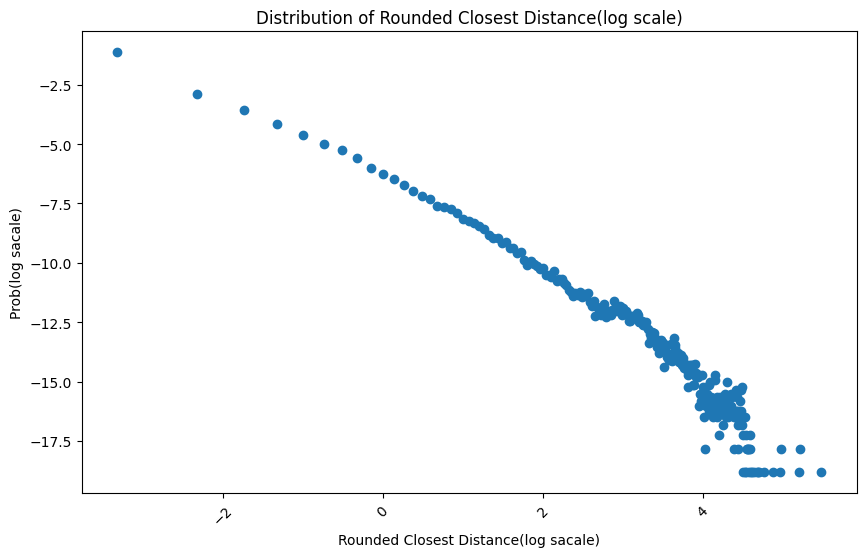

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data['rounded_distance'] = data['distance'].round(1)
# 로그를 취할 열 추가(ground_truth)
data['log_rounded_distance'] = np.log2(data['rounded_distance'])
data = data[data['log_rounded_distance'] != -np.inf] #반올림 결과가 0인 데이터 95183개 삭제

distance_counts = data['log_rounded_distance'].value_counts() # 거리별 방문횟수 저장
distance_counts.iloc[0] += 95183 # 0인 애들을 카운트가 가장 많은, 즉 가장 가까운 곳으로 다 더해줌

total_counts = distance_counts.sum()

print(distance_counts)
print("Counts의 합:", total_counts)

x1 = distance_counts.index # log2(distance)
y1 = np.log2(distance_counts.values / total_counts)

print(x1)
print(y1)

# 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정 (선택 사항)
plt.scatter(x1, y1)
plt.xlabel('Rounded Closest Distance(log sacale)')
plt.ylabel('Prob(log sacale)')
plt.title('Distribution of Rounded Closest Distance(log scale)')
#plt.ylim(0, 0.005)
#plt.xlim(0,1)
plt.xticks(rotation=45)  # x축 레이블 회전 (선택 사항)
plt.show()

In [ ]:
import torch
import torch.nn

X = torch.tensor(x1, dtype=torch.float32).view(-1, 1)
y = torch.tensor(y1, dtype=torch.float32).view(-1, 1)  # 확률, 2D 텐서로 변환

In [ ]:
# 모델 정의
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(1, requires_grad=True))
        self.w2 = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        return self.w1 + self.w2 * x

model = MyModel()
criterion = nn.MSELoss()  # 평균 제곱 오차 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 확률적 경사 하강법 사용

# 학습
num_epochs = 1000  # 학습 에포크 수
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    #if (epoch + 1) % 100 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 학습된 파라미터 출력
print(f'학습된 파라미터 w1: {model.w1.item():.4f}, w2: {model.w2.item():.4f}')

Epoch [1/1000], Loss: 149.6702
Epoch [2/1000], Loss: 82.3682
Epoch [3/1000], Loss: 46.1482
Epoch [4/1000], Loss: 26.6516
Epoch [5/1000], Loss: 16.1528
Epoch [6/1000], Loss: 10.4952
Epoch [7/1000], Loss: 7.4424
Epoch [8/1000], Loss: 5.7910
Epoch [9/1000], Loss: 4.8938
Epoch [10/1000], Loss: 4.4024
Epoch [11/1000], Loss: 4.1294
Epoch [12/1000], Loss: 3.9739
Epoch [13/1000], Loss: 3.8818
Epoch [14/1000], Loss: 3.8237
Epoch [15/1000], Loss: 3.7840
Epoch [16/1000], Loss: 3.7543
Epoch [17/1000], Loss: 3.7300
Epoch [18/1000], Loss: 3.7086
Epoch [19/1000], Loss: 3.6889
Epoch [20/1000], Loss: 3.6701
Epoch [21/1000], Loss: 3.6519
Epoch [22/1000], Loss: 3.6340
Epoch [23/1000], Loss: 3.6163
Epoch [24/1000], Loss: 3.5988
Epoch [25/1000], Loss: 3.5814
Epoch [26/1000], Loss: 3.5642
Epoch [27/1000], Loss: 3.5471
Epoch [28/1000], Loss: 3.5301
Epoch [29/1000], Loss: 3.5131
Epoch [30/1000], Loss: 3.4963
Epoch [31/1000], Loss: 3.4796
Epoch [32/1000], Loss: 3.4630
Epoch [33/1000], Loss: 3.4465
Epoch [34/10

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50444 (\N{HANGUL SYLLABLE SSYI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44163 (\N{HANGUL SYLLABLE GEOS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


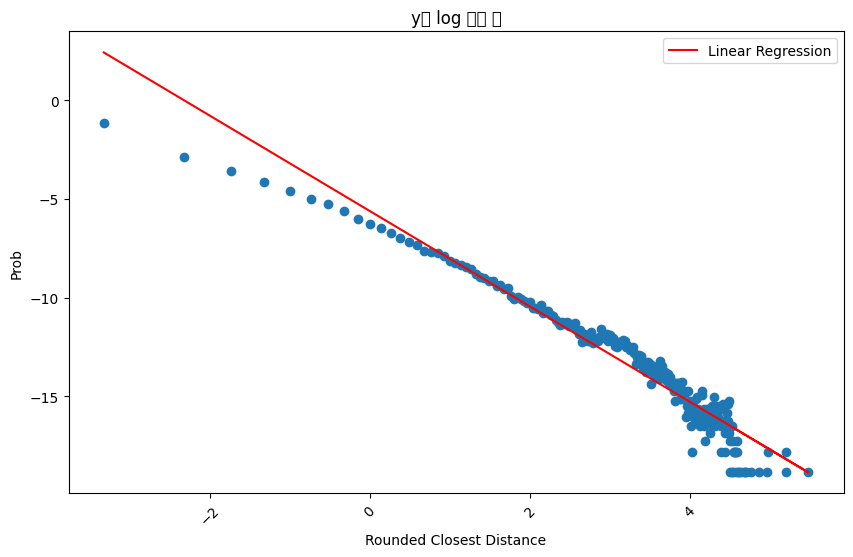

In [ ]:
# 선형 회귀 결과를 그래프로 표현
plt.figure(figsize=(10, 6))

plt.scatter(x1, y1)

# 선형 회귀 결과
plt.plot(X, model.w1.item() + model.w2.item() * X , color='red', label='Linear Regression')

plt.xlabel('Rounded Closest Distance')
plt.ylabel('Prob')
plt.title('y에 log 씌운 것')
plt.xticks(rotation=45)

plt.legend()
plt.show()

In [ ]:
b = model.w2.item()
#a = np.exp(model.w1.item())
a = 2 ** model.w1.item()

print(a,b)

x1 = np.arange(40)
x = x1 + 0.5
#print(x)
y = a * (x**b)
print(y)

0.02059073981980995 -2.4172468185424805
[1.09985580e-01 7.72708901e-03 2.24777445e-03 9.96609911e-04
 5.42870297e-04 3.34220123e-04 2.23182288e-04 1.57918458e-04
 1.16690905e-04 8.91810696e-05 7.00173012e-05 5.61957499e-05
 4.59377491e-05 3.81396098e-05 3.20891965e-05 2.73115558e-05
 2.34807930e-05 2.03677090e-05 1.78075889e-05 1.56797773e-05
 1.38943778e-05 1.23833835e-05 1.10946361e-05 9.98763179e-06
 9.03055939e-06 8.19817481e-06 7.47025437e-06 6.83045408e-06
 6.26545827e-06 5.76433695e-06 5.31805576e-06 4.91909864e-06
 4.56117470e-06 4.23898855e-06 3.94805902e-06 3.68457496e-06
 3.44527978e-06 3.22737832e-06 3.02846143e-06 2.84644437e-06]
